En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.


Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

# TOC

1. *[Lectura del conjunto de datos](#datos)*  
2. *[Modelos base](#base)*  
2.1. *[Promedio](#promedio)*  
2.2. *[Regresión lineal base](#rlb)*  
3. *[Transformación y selección de características](#tsc)*  
3.1. *[Transformación variables de entrada](#tvi)*  
3.2. *[Transformación de la variable de salida](#tvo)*  
3.3. *[Selección de características](#sc)*  
4. *[Redes neuronales](#ann)*  
4.1. *[Búsqueda de párametros óptimos](#gs)*

In [2]:
def set_filesystem():
    try:
        from google.colab import drive
        from os import chdir
    
        drive.mount('/content/drive/', force_remount=True)
        chdir("/content/drive/My Drive/evaluacion-lfsalazarz")
    except Exception as e:
        print(e)
    
set_filesystem()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.compose import TransformedTargetRegressor

%matplotlib inline

Funciones para graficas de desempeño

In [3]:
def evaluate_model_crossval(model, X, y, cv=5, seed=12345):
    kfold = KFold(n_splits=5, random_state=seed)
    scores = cross_val_score(model, X, y, cv=kfold)
    print(f'Cross-val score R2: {scores.mean():0.2f} (+/- {(scores.std() * 2):0.2f})')
    
    
def evaluate_model(model, X, y, di=0, df=350):
    y_pred = model.predict(X)    
    diag = np.linspace(di, df, 100)
    plt.figure(figsize=(7,7))
    plt.title(f'MSE: {mean_squared_error(y, y_pred):.2f}, R2: {r2_score(y, y_pred):.2f}')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    plt.plot(y, y_pred, 'o', markersize=3)
    plt.plot(diag, diag);
    plt.show();
    

def plot_mse(history):
    plt.plot(history.history['mean_absolute_error']) # mean_absolute_error, mean_squared_error
    plt.plot(history.history['val_mean_absolute_error']) # val_mean_absolute_error, val_mean_squared_error
    plt.title('model MSE')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

# 1. Lectura del conjunto de datos <a class="anchor" id="datos"></a>

In [2]:
df = pd.read_csv('datos/diabetes.csv')
print(f'Muestras: {df.shape[0]} Características: {df.shape[1] - 1}')

X = df.drop(['Y'], axis=1)
y = df['Y']

df.head()

Muestras: 442 Características: 10


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


# 2. Modelos base <a class="anchor" id="base"></a>

## 2.1. Promedio <a class="anchor" id="promedio"></a>

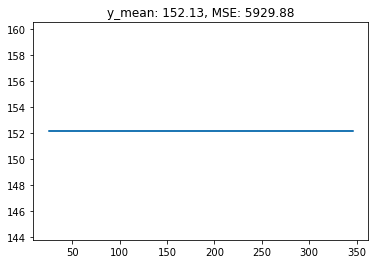

In [4]:
y_naive = y.mean()
y_naive_v = np.repeat(y_naive, len(y))
mse = mean_squared_error(y, y_naive_v)
plt.title(f'y_mean: {y_naive:.2f}, MSE: {mse:.2f}')
plt.plot(y, y_naive_v);

## 2.2. Regresión lineal base <a class="anchor" id="rlb"></a>

Cross-val score R2: 0.48 (+/- 0.10)


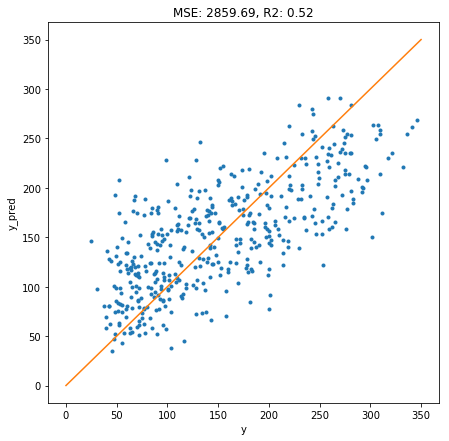

In [5]:
lr = LinearRegression()
lr.fit(X, y)
evaluate_model_crossval(lr, X, y)
evaluate_model(lr, X, y)

Ridge regression

Cross-val score R2: 0.41 (+/- 0.09)


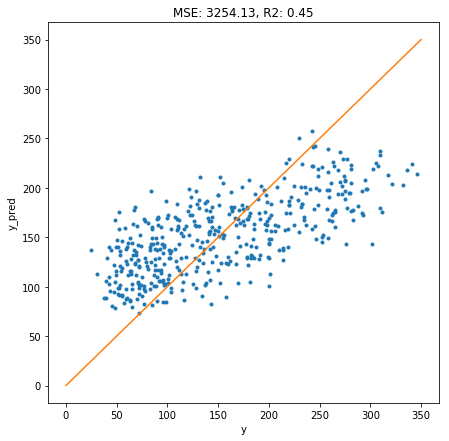

In [6]:
lr = Ridge(alpha=1.0)
lr.fit(X, y)
evaluate_model_crossval(lr, X, y)
evaluate_model(lr, X, y)

# 3. Transformación y selección de características <a class="anchor" id="tsc"></a>

### 3.1. Transformación variables de entrada <a class="anchor" id="tvi"></a>

Se aplica la transformación **_PolynomialFeatures_**, la cual genera una nueva matriz que consiste en todas las combinaciones de los polinomios de un grado menor o igual al especificado, por ejemplo, si la entrada es de la forma \[a, b\], la matriz resultante de grado 2 es \[1, a, b, a^2, ab, b^2\].

In [7]:
from sklearn.preprocessing import PolynomialFeatures

In [8]:
poly = PolynomialFeatures(degree=2)
poly_variables = poly.fit_transform(X)

# Se obtiene los nombres de las columnas de la nueva matriz
colnames = np.array(poly.get_feature_names(X.columns)[1:])

# Se elimina la columna de unos
poly_variables = poly_variables[:,1:]
poly_variables.shape

(442, 65)

In [9]:
colnames

array(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'age^2', 'age sex', 'age bmi', 'age bp', 'age s1', 'age s2',
       'age s3', 'age s4', 'age s5', 'age s6', 'sex^2', 'sex bmi',
       'sex bp', 'sex s1', 'sex s2', 'sex s3', 'sex s4', 'sex s5',
       'sex s6', 'bmi^2', 'bmi bp', 'bmi s1', 'bmi s2', 'bmi s3',
       'bmi s4', 'bmi s5', 'bmi s6', 'bp^2', 'bp s1', 'bp s2', 'bp s3',
       'bp s4', 'bp s5', 'bp s6', 's1^2', 's1 s2', 's1 s3', 's1 s4',
       's1 s5', 's1 s6', 's2^2', 's2 s3', 's2 s4', 's2 s5', 's2 s6',
       's3^2', 's3 s4', 's3 s5', 's3 s6', 's4^2', 's4 s5', 's4 s6',
       's5^2', 's5 s6', 's6^2'], dtype='<U7')

### 3.2. Transformación de la variable de salida <a class="anchor" id="tvo"></a>

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
#scaler = MinMaxScaler()
#y_scale = scaler.fit_transform(y.values.reshape(-1, 1))
#y_scale = y_scale.reshape(-1)

y_log1p = np.log1p(y)

### 3.3. Selección de características <a class="anchor" id="sc"></a>

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [13]:
# Mejores 20 características
selector = SelectKBest(score_func=f_regression, k=20)
X_new = selector.fit_transform(poly_variables, y_log1p)

print(colnames[selector.get_support()])

['age' 'bmi' 'bp' 's1' 's2' 's3' 's4' 's5' 's6' 'age s2' 'bmi^2' 'bmi bp'
 'bmi s2' 'bmi s6' 'bp^2' 's2 s5' 's3^2' 's4^2' 's4 s6' 's6^2']


**Separar el conjunto de datos**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_log1p, test_size=0.35, random_state=12345)

In [15]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)

X_train (287, 20)
X_test (155, 20)


# 4. Redes neuronales <a class="anchor" id="ann"></a>

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [17]:
def build_regressor():    
    model = Sequential()    
    
    model.add(Dense(units=8, activation='relu', input_shape=(20,)))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    
    return model

In [18]:
model = build_regressor()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 168       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)

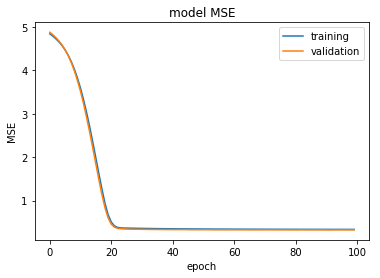

In [20]:
plot_mse(history)

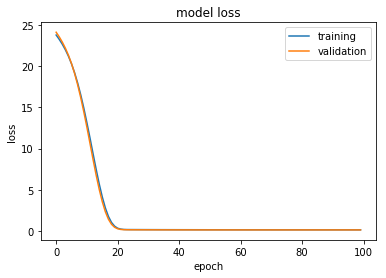

In [21]:
plot_loss(history)

**Validación cruzada**

In [22]:
seed = 12345
np.random.seed(seed)
kfold = KFold(n_splits=3, random_state=seed)
estimator = KerasRegressor(build_fn=build_regressor, epochs=100, verbose=0)
results_cv = cross_val_score(estimator, X_new, y_log1p, cv=kfold, scoring='neg_mean_squared_error')

In [23]:
print(f'MSE: {np.abs(results_cv.mean()):.2f} +/- {results_cv.std() * 2:.2f}')

MSE: 0.17 +/- 0.02


### 4.1 Búsqueda de párametros óptimos <a class="anchor" id="gs"></a>

In [25]:
def build_regressor(n1, n2):    
    model = Sequential()    
    
    model.add(Dense(units=n1, activation='relu', input_shape=(20,)))
    model.add(Dense(units=n2, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    
    return model

In [26]:
parameters = {
    'n1': [4, 8, 16, 32, 64],
    'n2': [4, 8, 16, 32, 64]
}

kfold = KFold(n_splits=3, random_state=12345)
estimator = KerasRegressor(build_fn=build_regressor, epochs=100, verbose=0)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=kfold,
)

grid_search = grid_search.fit(X_new, y_log1p)

best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(best_parameters)
print('best_accuracy ', np.abs(best_accuracy))

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (np.abs(mean), stdev, param))

/home/lfsz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n1': 64, 'n2': 16}
best_accuracy  0.1693577813968364
5.362745 (7.340658) with: {'n1': 4, 'n2': 4}
0.187558 (0.021047) with: {'n1': 4, 'n2': 8}
0.173478 (0.011371) with: {'n1': 4, 'n2': 16}
0.172350 (0.009797) with: {'n1': 4, 'n2': 32}
0.173477 (0.010413) with: {'n1': 4, 'n2': 64}
5.354579 (7.340483) with: {'n1': 8, 'n2': 4}
0.179039 (0.018420) with: {'n1': 8, 'n2': 8}
0.170938 (0.007667) with: {'n1': 8, 'n2': 16}
0.170866 (0.007412) with: {'n1': 8, 'n2': 32}
0.170096 (0.007306) with: {'n1': 8, 'n2': 64}
0.174758 (0.012503) with: {'n1': 16, 'n2': 4}
0.172048 (0.008100) with: {'n1': 16, 'n2': 8}
0.171547 (0.008578) with: {'n1': 16, 'n2': 16}
0.172896 (0.006950) with: {'n1': 16, 'n2': 32}
0.170401 (0.005906) with: {'n1': 16, 'n2': 64}
0.170669 (0.009357) with: {'n1': 32, 'n2': 4}
0.171165 (0.006623) with: {'n1': 32, 'n2': 8}
0.170128 (0.006593) with: {'n1': 32, 'n2': 16}
0.171364 (0.005835) with: {'n1': 32, 'n2': 32}
0.172280 (0.008270) with: {'n1': 32, 'n2': 64}
0.171145 (0.006947) wit

In [27]:
model = build_regressor(64, 16)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_240 (Dense)            (None, 64)                1344      
_________________________________________________________________
dense_241 (Dense)            (None, 16)                1040      
_________________________________________________________________
dense_242 (Dense)            (None, 1)                 17        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)

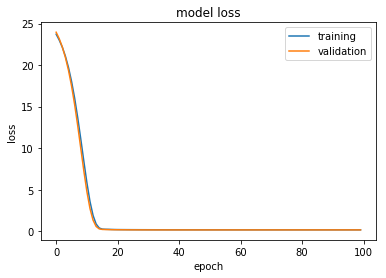

In [29]:
plot_loss(history)

**validación cruzada**

In [30]:
seed = 12345
np.random.seed(seed)
kfold = KFold(n_splits=3, random_state=seed)
estimator = KerasRegressor(build_fn=build_regressor, n1=64, n2=16, epochs=100, verbose=0)
results_cv = cross_val_score(estimator, X_new, y_log1p, cv=kfold, scoring='neg_mean_squared_error')

In [31]:
print(f'MSE: {np.abs(results_cv.mean()):.2f} +/- {results_cv.std() * 2:.2f}')

MSE: 0.17 +/- 0.01
